In [1]:
import ticktack
from jax.numpy import array, pi, exp, sin, mean, median, var, arange
from numpy import random
from scipy.stats import ttest_ind
from pandas import read_csv, DataFrame, concat
from plotnine import ggplot, geom_line, labs, aes, geom_point, theme_bw

The basic question is what is the probability of detecting consecutive events based on the distribution of the data. The first step then will be to determine the distribution of the data. This will be done be resampling the points after the event has been removed.

In [2]:
models = { # This dictionary contains the units for the fluxes and production function
    "Guttler14": {  # Units of the Guttler 2014 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production rate 
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes
    },
    "Brehm21": {    # Units used by the Brehm, et. al. paper
        "production_rate_units": "",    # Units of the production rate 
        "flow_rate_units": ""           # Units of the fluxes
    },
    "Buntgen18": {  # The units used by the Buntgen 2018 paper
        "production_rate_units": "",    # Units of the production function
        "flow_rate_units": ""           # Units of the fluxes 
    },
    "Miyake17": {   # The units used by the Miyake 2017 et. al. paper
        "production_rate_units": "",    # Units of the production function 
        "flow_rate_units": ""           # Units of the fluxes.
    }
}

The function below will also have a `shape` parameter eventually. First however I want to get this running. Damn this really is well suited to a class structure since then I can set `self.set_annual_samples()` need to check if this has actually been implemented. The answer is __No__. I need to add the growth seasons to the `model_units` (which I might just rename `models`). This will lead to ?two? extra field `hemisphere_model` (bool) and `growth_seasons`. Alternatively this could result in a further nested dictionary like `hemispheres = {"NH_growth": array([]), "SH_growth": array([])}`

In [3]:
def get_model(model: str):
    cbm = ticktack.load_presaved_model( # Generating the CarbobBoxModel using ticktack
        model,  # Name of the model as looped from the models dictionary 
        production_rate_units=models[model]["production_rate_units"], 
        flow_rate_units=models[model]["flow_rate_units"]
    )

    bayesian_model = ticktack.fitting.SingleFitter(model)   # Fitting a model 
    bayesian_model.prepare_function(model="simple_sinusoid")# Generating the simple sin model 

    return bayesian_model

In [4]:
model = get_model("Guttler14")

INFO[2021-12-21 12:38:49,875]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2021-12-21 12:38:49,876]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2021-12-21 12:38:49,878]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2021-12-21 12:38:49,879]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
def get_production_function(model: ticktack.fitting.SingleFitter, data: str):
    """
    Parameters:
        model: `str` - The `CarbonBoxModel` that is to be used
        data: `str` - The dataset that the production function is to be fitted to (.csv)
    Returns:
        production: `function` - The ideal production function 
    """
    model.load_data(data)                          # Loading the data into the model 

    samples = model.MarkovChainSampler(    # An array of samples for all of the parameters
        array([775., 1./12, pi/2., 81./12]),    # Initial position within the parameters space    
        likelihood=model.log_likelihood,   # likelihood function 
        burnin=200,                             # Truncated burnin for testing 
        production=500                          # Truncated production for testing 
    )

    parameters = {  # A dictionary of the model parameters for the `simple_sinusoid`
        "Start Date (yr)": None,    # The year that the event began 
        "Duration (yr)": None,      # Number of years that the event occured over 
        "Phase (yr)": None,         # The phase shift of the sinusoidal production function 
        "Area": None               #? What are the units?
    } 

    for i, parameter in enumerate(parameters):  # Looping through the parameters 
        parameters[parameter] = {   # Nested dictionary to store statistical information
            "mean": mean(samples[:, i]),    # Storing the mean of the samples produced by mcmc
            "median": median(samples[:, i]),# Storing the median in addition to the mean 
            "variance": var(samples[:, i])  # Storing the variance of the parameter
        }
    parameters["Steady Production"] = model.steady_state_production   
    
    return parameters

In [6]:
params = get_production_function(model, "Miyake12.csv")

Running burn-in...


100%|██████████| 200/200 [00:16<00:00, 11.84it/s]


Running production...


100%|██████████| 500/500 [00:48<00:00, 10.38it/s]


In [7]:
def production(t: float, params: dict):
    """
    The best fit production function as estimated using `mcmc`
    """
    middle = params["Start Date (yr)"]["mean"] + \
        params["Duration (yr)"]["mean"] / 2.0    # Calculating the center of the event
    height = params["Area"]["mean"] / params["Duration (yr)"]["mean"] # The magnitude of the event 

    gauss = height * exp(- ((t - middle) / (1. / 1.93516 * \
        params["Duration (yr)"]["mean"])) ** 16.)   # The super-gaussian event

    sine = params["Steady Production"] + \
        0.18 * params["Steady Production"] * \
        sin(2 * pi / 11 * t + params["Phase (yr)"]["mean"]) # Sinusoidal component of production 
    
    return sine + gauss

We are getting some inefficiency by loading the data twice. I may look into avoiding the use of the `SingleFitter` to get around this but it is not ideal.

In [8]:
def get_residual_distribution(production, model: ticktack.fitting.SingleFitter, data: str, params: dict):
    """
    Parameters:
        production: function - The production function, typically determined using `get_production_function`.
        data: str - The file name of the data. Should be the same as the file name that was provided to `get_production_function`.
    Returns:
        An `mcmc` sample of the posterior distribution of the residuals, which has been fitted with a parameteric (to start) distribution that can be used to simulate noise.
    """
    #* I need to work out how to include the measurement uncerainty in my parametric fitting
    #* I also need to work out how to test for normaility
    data = read_csv(data, sep=" ")  # Reading the data into the namespace #! CHECK SEP

    model.production = production   # Setting the production function 
    residuals = array([*data["d14c"]]) - model.dc14(params)

    #* Should look into mae error reporting for the variance and mean. 
    #! Should be using mcmc here to get a better estimate for the mean and the variance ext.

    gaussian_error_parameters = {   # Dictionary containing the parameters of a parametric gaussian
        "residuals": {   # The statistical error in the residuals 
            "mean": mean(residuals),    # The mean of the residuals assumed to have gaussian error
            "variance": var(residuals)  # Variance of the residuals assumed to have gaussian error
        },
        "error": {  # The statistical distribution of the measurement error
            "mean": mean(array([*data["sig_d14c"]])),   # Mean measurement error
            "variance": var(array([*data["sig_d14c"]])) # Variance of measurement error 
        }
    }

    return gaussian_error_parameters
    

In [14]:
gaussian_error = get_residual_distribution(production, model, "Miyake12.csv", [params])

So the error in the data measurements will have a distribution that I can use to generate imaginary error in the data. I'm not sure how this will help but it could change the way things shape out so I will implement this and keep track of it. 

In [15]:
def simulate_event(model: ticktack.fitting.SingleFitter, error: dict, params: dict):
    """
    Simulates a Miyake event based on the things that have already transpired. 
    """   
    model.production = production   # Production function with the new parameters
    core_data_stream = model.dc14(params) # Model generation

    random_error = random.randn(len(core_data_stream)) * \
        error["residuals"]["variance"] + error["residuals"]["mean"] # Generating the noise 
    
    measurement_error = random.randn(len(core_data_stream)) * \
        error["error"]["variance"] + error["error"]["mean"]

    data = {    # A Dictionary that I will convert to a DataFrame and return 
        "Year": model.time_data,                # The time series data 
        "DC14": core_data_stream + random_error,# Simulated C14 data
        "Sig_DC14": measurement_error           # Simulated C14 measurement error
    }

    return DataFrame(data)

Better commenting for below

In [17]:
simulations = []   # Preinitialising a list to store the simulations
for area in arange(0.0, 8.0):   # Looping over a range of areas 
    for duration in arange(0.0, 8.0):   # Looping over a range of durations
        event_params = params.copy()                        # Copying the parameters dictionary 
        event_params["Area"]["mean"] = area                 # Updating the area parameter
        event_params["Duration (yr)"]["mean"] = duration    # Changing the duration 

        event = simulate_event(model, gaussian_error, [event_params]) # Running simulation 
        event["Area"] = [area for i in range(len(event))]           # Adding area parameter value
        event["Duration"] = [duration for i in range(len(event))]   # Addinf duration parameter
        simulations.append(event)  # Storing the simulation

simulations = concat(simulations)   # Simplifying into large dataframe

/home/jordan/anaconda3/envs/ticktack/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 224 rows containing missing values.


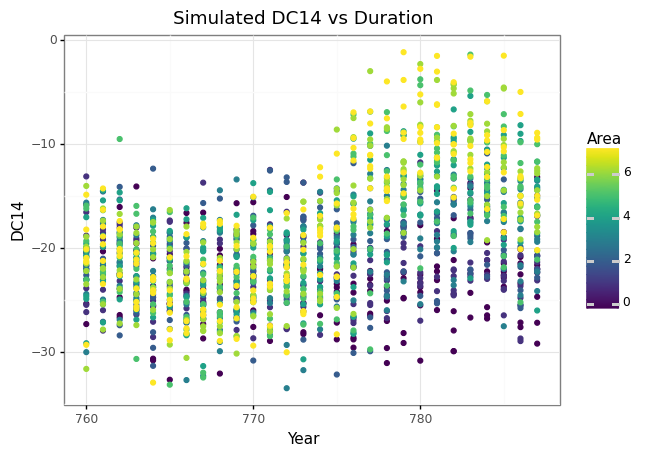

<ggplot: (8738170040456)>

In [18]:
(ggplot(simulations, aes(x="Year", y="DC14", color="Area"))
    + geom_point()
    + theme_bw()
    + labs(title="Simulated DC14 vs Duration")
)

In [55]:
p_values = {        # A new array to store the values 
    "Area": [],     # Area of test 
    "Duration": [], # Duration of simulation 
    "P": []         # The associated p value of the simulation
}

for area in arange(0.0, 8.0):   # Looping over a range of areas 
    for duration in arange(0.0, 8.0):   # Looping over a range of durations
        event_data = simulations[simulations["Area"] == area]
        event_data = event_data[event_data["Duration"] == duration]

        before_event = event_data[event_data["Year"] < params["Start Date (yr)"]["mean"]]
        before_event = array([*before_event["DC14"]])

        after_event = event_data[event_data["Year"] > params["Start Date (yr)"]["mean"]]
        after_event = array([*after_event["DC14"]])

        p_values["Area"].append(area)
        p_values["Duration"].append(duration)
        p_values["P"].append(ttest_ind(before_event, after_event)[1])

p_values = DataFrame(p_values)